# Data Mining and Machine Learning - Team Tissot 
## Ensemble Voting Classifier with TfifdVectorizer and with Word2Vec


***Detecting the difficulty level of French texts***

In this notebook we attempted to achieve greater accuracy by using the Ensemble Voting Classifier with TfifdVectorizer and then with Word2Vec.

**Plan :**

1. Importing necessary packages, functions and the data

2. Ensemble models with TfidfVector

3. Ensemble model with Word2Vec

# 1. Importing necessary packages, functions and the data


In [ ]:
# Download and update spaCy
!pip install -U spacy

# Download and update the french language model
!python -m spacy download fr

# Download and update mlrose (for the ensemble model)
!pip install mlrose

In [ ]:
# Import required packages
%matplotlib inline
import numpy as np
import pandas as pd 
import seaborn as sns
sns.set_style("whitegrid")
import string
import gensim
import six
import sys
sys.modules['sklearn.externals.six'] = six
import mlrose

# Import required packages
import spacy
from spacy import displacy

# Load French language model
sp = spacy.load("fr_core_news_sm")

# Import and load the required packages for the Word2Vec
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize 
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Import some additional packages
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
from google.colab import files

> Import our custom functions from our github repo

In [ ]:
!pip install requests
import requests

url = "https://raw.githubusercontent.com/danieldovale/DMML2022_Tissot/main/code/custom_functions.py"
r = requests.get(url)

# Make sure your filename is the same as how you want to import 
with open('custom_functions.py', 'w') as f:
    f.write(r.text)
print(r.text)

# Now we can import
import custom_functions as cfun

> Loading the data and setting "id" as the index column

In [ ]:
# Training data:
dfTrain = pd.read_csv("https://raw.githubusercontent.com/danieldovale/DMML2022_Tissot/main/data/training_data.csv", index_col='id')

# Unlabeled test data:
dfTest = pd.read_csv("https://raw.githubusercontent.com/danieldovale/DMML2022_Tissot/main/data/unlabelled_test_data.csv", index_col='id')

> Split the dataset of dfTrain to train and test our models
>
>*   80% to train
>*   20% to test

In [ ]:
X = dfTrain["sentence"]
y = dfTrain["difficulty"]

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# 2. Ensemble models with TfidfVector

## 2.1 An example of an ensemble model with the TfidfVecotizer. 


> First, we define a spacy tokenizer to clean the data we lowercase and lemmatize all the words. 

In [ ]:
def spacy_tokenizer(sentence):
    # Create token object, which is used to create documents with linguistic annotations
    mytokens = sp(sentence)
    # Lemmatize each token and convert each token into lowercase
    mytokens = [ word.lower_.strip() for word in mytokens] 
    # Return preprocessed list of tokens
    return mytokens

> The token for the TfidfVector with the spacy toknizer define above

In [ ]:
tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer, ngram_range=(1,2)) 

> The 3 classifiers that will be use in the ensemble model :
>
> 1.   Logistic Regression (logclf)
2.   Decision Tree Classifier (dtclf)
3.   K-Nearest Neighbors (knnclf)


In [ ]:
# Import some the packages of all the models that we will use here
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Set up the classifiers with some parameters
logclf = LogisticRegression(C=10, max_iter=20000, random_state=0)
dtclf = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)
knnclf = KNeighborsClassifier()

> The EnsembleVoteClassifier with the 3 classifiers 
 
The parameters :
* clfs = list of classifiers (logclf, dtclf, knnclf)
* weights = [2, 1.5, 1] (2 for the logclf, 1.5 for the dtclf, 1 for the knnclf)

*The others parameters set with the defaults values (like voting='hard', it predicts the class labels (A1,...C2) with the majority rule voting).*

In [ ]:
# Import the package for the Ensemble
from mlxtend.classifier import EnsembleVoteClassifier

# Set up the ensemble classifier
clf_ens = EnsembleVoteClassifier(clfs=[logclf, dtclf, knnclf], weights=[2, 1.5, 1])

# Vectorizer and train the dataset (X_train)
pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', clf_ens)])

# Train the model
pipe.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(ngram_range=(1, 2),
                                 tokenizer=<function spacy_tokenizer at 0x7f29e0093940>)),
                ('classifier',
                 EnsembleVoteClassifier(clfs=[LogisticRegression(C=10,
                                                                 max_iter=20000,
                                                                 random_state=0),
                                              DecisionTreeClassifier(criterion='entropy',
                                                                     max_depth=3,
                                                                     random_state=0),
                                              KNeighborsClassifier()],
                                        weights=[2, 1.5, 1]))])

> Evaluate the fitted model

,accuracy,precision,recall,f1 score
results,0.45,0.4625,0.45,0.4357


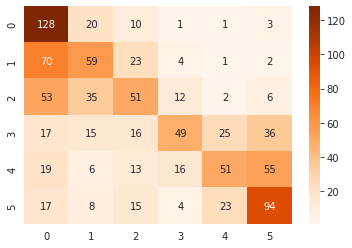

In [ ]:
# Predict the y of the X_test dataset
y_pred = pipe.predict(X_test)

# Evaluate the model (confusion matrix)
cfun.evaluate(y_test, y_pred)

In [ ]:
cfun.class_accuracy(y_test, y_pred)

A1: 0.79%
A2: 0.37%
B1: 0.32%
B2: 0.31%
C1: 0.32%
C2: 0.58%


As we can see, the accuracy of this model is only 0.45, which is not a significant improvement. When compared to the basic Logistic Regression with the same parameters, this model has lower accuracy, precision, recall, and f1 score.

Examining the diagonal of the confusion matrix, we observe that, similar to the other models we have tried, the A1 (top-left cell) and the C2 (bottom-right cell) are the best-predicted levels. Finally, by looking at the left column, we can see that there is a problem with this ensemble because a lot of sentences are misclassified as A1. 

> Submit the model to see the final score.

In [ ]:
# Submit the model train with X_train (the train part of dfTrain)
predDifficulty = pipe.predict(dfTest['sentence'])

cfun.prediction(predDifficulty, 'Ensemble_tfidf_example')

,difficulty
id,
0,C2
1,B1
2,A1
3,B1
4,C2


The score of the submission is 0.4458. 

It is a bit lower but still close to the accuracy computed with the test dataset from dfTrain.


## 2.2 The best model found with the TfidfVectorizer

> We use the same tokenizer that will lowercase all the word.  

In [ ]:
def spacy_tokenizer(sentence):
    # Create token object, which is used to create documents with linguistic annotations.
    mytokens = sp(sentence)
    # Lemmatize each token and convert each token into lowercase
    mytokens = [ word.lower_.strip() for word in mytokens ] 
    # Return preprocessed list of tokens
    return mytokens


tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer, ngram_range=(1,2)) 

> The 3 classifiers that will be use in the ensemble model :
>
> 1.   Logistic Regression (logclf)
2.   Multi-layer Perceptron classifier (mlpclf)
3.   Decision Tree Classifier (dtclf)

In [ ]:
# Import some the packages of all the models that we will use here
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

logclf = LogisticRegression(max_iter=5000, random_state=0)
mlpclf = MLPClassifier(max_iter=1000, random_state=0)
rfclf = RandomForestClassifier(n_estimators=350, random_state=0)

> The EnsembleVoteClassifier with the 3 classifiers 
 
The parameters :
* clfs = list of classifiers (logclf, mlpclf, rfclf)
* weights = [1.5, 2, 1.5] (1.5 for the Logistic Regression, 2 for the MLP and 1.5 for the Random Forest) 

*The others parameters set with the defaults values.*

In [ ]:
clf_ens = EnsembleVoteClassifier(clfs=[logclf, mlpclf, rfclf], weights=[1.5, 2, 1.5])

# Vectorizer and train the dataset (X_train)
pipe = Pipeline([('vectorizer', tfidf_vector),
                 ('classifier', clf_ens)])

pipe.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(ngram_range=(1, 2),
                                 tokenizer=<function spacy_tokenizer at 0x7f29db6791f0>)),
                ('classifier',
                 EnsembleVoteClassifier(clfs=[LogisticRegression(max_iter=5000,
                                                                 random_state=0),
                                              MLPClassifier(max_iter=1000,
                                                            random_state=0),
                                              RandomForestClassifier(n_estimators=350,
                                                                     random_state=0)],
                                        weights=[1.5, 2, 1.5]))])

> Evaluate the fitted model

,accuracy,precision,recall,f1 score
results,0.4812,0.4809,0.4812,0.4736


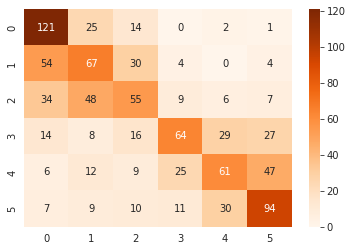

In [ ]:
# Predict the y of the X_test dataset
y_pred = pipe.predict(X_test)

# Evaluate the model (confusion matrix)
cfun.evaluate(y_test, y_pred)

To improve the model, we have use other classifiers with better parameters. The accuracy has encrease and is now close to 0.48 for all the metrics. 

The confusion matrix also shows that more sentences have been correctly predicted by the model, and there are fewer instances of significant misclassification (e.g., predicting A1 but the correct label is C2).

> Submit the model to see the final score.

In [ ]:
# Submit the model train with X_train (the train part of dfTrain)
predDifficulty = pipe.predict(dfTest['sentence'])

cfun.prediction(predDifficulty, 'Ensemble_tfidf')

,difficulty
id,
0,C2
1,B1
2,A1
3,A1
4,C2


The score of the submission is 0.4675.

It's lower then accuracy that we have with the test dataset from dfTrain. However, we have still improved the accuracy of the predictions made with this new list of classifiers. The accuracy has increased from 0.446 to 0.468, representing an improvement of almost 2 percentage points.

# 3. Ensemble models with Word2Vec

## 3.1 Set up the base for the model

### 3.1.1 Cleaning and tokenizing the sentences

> First, let's clean the sentences by removing the stop words and the punctuation, and also lowercase all the words.

In [ ]:
# Set the list of stop words and punctuation
stop_words = spacy.lang.fr.stop_words.STOP_WORDS
punctuations = string.punctuation

> We gather some additional information about the sentences using our [custom function](https://raw.githubusercontent.com/danieldovale/DMML2022_Tissot/main/code/custom_functions.py) get_info().

In [ ]:
# Get all the information about the dataset dfTrain
dfTrainInfo = cfun.get_info(dfTrain)

100%|██████████| 4800/4800 [01:19<00:00, 60.21it/s]



> Next, we define a spacy tokenizer to clean the data we lowercase and lemmatize all the words. 

In [ ]:
def spacy_tokenizer(sentence):
    # Create token object, which is used to create documents with linguistic annotations
    mytokens = sp(sentence)

    # Lemmatize each token and convert each token into lowercase
    mytokens = [ word.lemma_.lower().strip() for word in mytokens ] 
    
    # Return preprocessed list of tokens
    return mytokens

> Tokenizing every words in dfTrain and dfTest to feed it as vocabulary to Word2Vec.

In [ ]:
# Tokenize texts from the dataset dfTrain
processed_texts = []
for text in tqdm(dfTrain["sentence"]):
  processed_text = spacy_tokenizer(text)
  processed_texts.append(processed_text)

100%|██████████| 4800/4800 [01:06<00:00, 72.36it/s]


In [ ]:
# Tokenize texts from the dataset dfTest
processed_texts_test = []
for text in tqdm(dfTest["sentence"]):
  processed_text_test = spacy_tokenizer(text)
  processed_texts_test.append(processed_text_test)

100%|██████████| 1200/1200 [00:13<00:00, 86.04it/s]


In [ ]:
# After Tokenize both dataset, we join the two processed dataset. 
processed_texts_both = processed_texts + processed_texts_test

### 3.1.2 Vectorize with Word2Vec

In [ ]:
# Necessary function to set a fixed random state to Word2Vec
def hash(astring):
   return ord(astring[0])

In [ ]:
# Building Word2Vec model
model = gensim.models.Word2Vec(size=512, window=50, min_count=1, workers=1, seed = 0, hashfxn=hash)
model.build_vocab(processed_texts_both)

# Train model on preprocessed sentences
model.train(processed_texts_both, total_examples=len(processed_texts_both), epochs=100)

(8323807, 12880800)

>Building dataframe with vectors

In [ ]:
# Applying Word2Vec vectorizer to every sentence in dfTrain
# Note that the result of the each token is divided by the len of the sentence.
vectors = []
for sent in tqdm(processed_texts):
      vectors.append(sum(model[token] for token in sent)/len(sent))

  0%|          | 0/4800 [00:00<?, ?it/s]<ipython-input-14-0ee4a6e1c4bd>:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vectors.append(sum(model[token] for token in sent)/len(sent))
100%|██████████| 4800/4800 [00:00<00:00, 7981.67it/s]


In [ ]:
# Create a dataframe with all the vectors
dfVectors = pd.DataFrame(vectors)

# Concatenating vectors and info dataframes
dfFinal = pd.concat([dfVectors, dfTrainInfo], axis = 1)

> Slip the processed sentences to train the model and test it. 
>
>*   80% to train
>*   20% to test

In [ ]:
X = dfFinal
y = dfTrain['difficulty']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## 3.2 The Ensemble with Word2Vec 

#### 3.2.1 An simple example of an Ensemble with Word2Vec

> The 3 classifiers that will be use in the ensemble model :
>
> 1.   Logistic Regression (logclf)
2.   Decision Tree Classifier (dtclf)
3.   Linear Support Vector Classifier (svcclf)

In [ ]:
# Import some additional packages 
from sklearn.svm import LinearSVC

# Set up the classifiers with some parameters
logclf = LogisticRegression(C=10, max_iter=15000, random_state=0)
dtclf = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)
svcclf = LinearSVC(max_iter=2000, tol=0.001, random_state=0)

> The EnsembleVoteClassifier with the 3 classifiers 
 
The parameters :
* clfs = list of classifiers (logclf, dtclf, svcclf)
* weights = [2, 1.5, 1] (2 for the logclf, 1.5 for the dtclf, 1 for the svcclf)

*The others parameters set with the defaults values (like voting='hard', it predicts the class labels (A1,...C2) with the majority rule voting).*

In [ ]:
# Set up the ensemble classifier
clf_ens = EnsembleVoteClassifier(clfs=[logclf, dtclf, svcclf],weights=[2,1.5,1])

# Train the model
clf_ens.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


EnsembleVoteClassifier(clfs=[LogisticRegression(C=10, max_iter=15000,
                                                random_state=0),
                             DecisionTreeClassifier(criterion='entropy',
                                                    max_depth=3,
                                                    random_state=0),
                             LinearSVC(max_iter=2000, random_state=0,
                                       tol=0.001)],
                       weights=[2, 1.5, 1])

> Evaluate the fitted model

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


,accuracy,precision,recall,f1 score
results,0.4385,0.4842,0.4385,0.4338


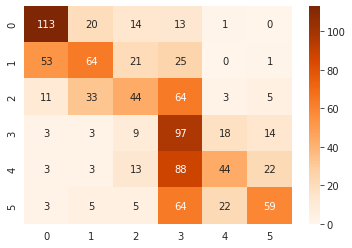

In [ ]:
# Predict the y of the X_test dataset
y_pred = clf_ens.predict(X_test)

# Evaluate the prediction
cfun.evaluate(y_test, y_pred)

For this example, we randomly selected 3 classifiers that we had previously tested individually. We found that the combination of logistic regression, decision tree, and linear SVC resulted in a more accurate model overall. However, all metrics are still below 0.5.

Analysing the confusion matrix, we can see that there are even fewer misclassified sentences, and the A1 sentences are the ones that are most accurately classified.

> Submit the model to see the final score.

In [ ]:
# Vectorize the dfTest to predict the values with the train model
vectors_test = []
for sent in processed_texts_test:
    vectors_test.append(sum(model[token] for token in sent)/len(sent))

dfVectorsTest = pd.DataFrame(vectors_test)
dfTestInfo = cfun.get_info(dfTest)
dfFinalTest = pd.concat([dfVectorsTest, dfTestInfo], axis = 1)

<ipython-input-34-e305cfd863fa>:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vectors_test.append(sum(model[token] for token in sent)/len(sent))
100%|██████████| 1200/1200 [00:13<00:00, 89.64it/s]


In [ ]:
# Submit the model train with X_train (the train part of dfTrain)
predDifficulty = clf_ens.predict(dfFinalTest)

cfun.prediction(predDifficulty, 'Ensemble_w2v_example_1')

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


,difficulty
id,
0,C2
1,A2
2,B2
3,B2
4,C2


In [ ]:
# Submit the model train on the whole dfTrain
clf_ens.fit(X, y)

predDifficulty = clf_ens.predict(dfFinalTest)

cfun.prediction(predDifficulty, 'Ensemble_w2v_example_2')

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Score of the submissions : 

*   Train on the split dfTrain (X_train) : 0.45333
*   Train on the whole dfTrain : 0.4525

Unfortunately, the results are not as promising as we had hoped. Despite having a higher accuracy with Word2Vec than with TfidfVector for the test dataset of dfTrain, the model performed worse when making predictions on the sentences that we submitted. 

#### 3.2.2 The best model found with an Ensemble and Word2Vec

> The 3 classifiers that will be use in the ensemble model :
>
> 1.   Logistic Regression (logclf)
2.   Random Forest Classifier (rfclf)
3.   Multi-layer Perceptron classifier (mlpclf)


In [ ]:
# Set up the classifiers with some parameters
logclf = LogisticRegression(C = 10, max_iter = 20000, random_state = 0)
mlpclf = MLPClassifier(max_iter=1000, random_state=0)
rfclf = RandomForestClassifier(n_estimators=350, random_state=0)

> The EnsembleVoteClassifier with the 3 classifiers 
 
The parameters :
* clfs = list of classifiers (logclf, rfclf, mlpclf)
* weights = [1.5, 1, 1] (1.5 for the logclf, 1 for the mlpclf, 1 for the rfclf)

*The others parameters set with the defaults values (like voting='hard', it predicts the class labels (A1,...C2) with the majority rule voting).*

In [ ]:
# Set up the ensemble classifier
clf_ens = EnsembleVoteClassifier(clfs=[logclf, mlpclf, rfclf],weights=[2,1.5,1])

# Train the model
clf_ens.fit(X_train, y_train)

> Evaluate the fitted model

In [ ]:
# Predict the y of the X_test dataset
y_pred = clf_ens.predict(X_test)

# Evaluate the prediction
cfun.evaluate(y_test, y_pred)

In [ ]:
cfun.class_accuracy(y_test, y_pred)

We have again surpassed the threshold of 0.5 for all evaluation metrics. With a score close to 0.52, this is the one of the best model that we have found for predicting the class of each sentence. In addition, we can note that we have the exact same results as the metrics found in the Word2Vec model. 

Examing the confusion matrix, we can see that some sentences are still completely misclassified. However, the error of classification is lower, as more and more sentences are closer to the correct class.

> Submit the model to see the final score.

In [ ]:
# Vectorize the dfTest to predict the values with the train model
vectors_test = []
for sent in processed_texts_test:
    vectors_test.append(sum(model[token] for token in sent)/len(sent))

dfVectorsTest = pd.DataFrame(vectors_test)
dfTestInfo = cfun.get_info(dfTest)
dfFinalTest = pd.concat([dfVectorsTest, dfTestInfo], axis = 1)

In [ ]:
# Submit the model train with X_train (the train part of dfTrain)
predDifficulty = clf_ens.predict(dfFinalTest)

cfun.prediction(predDifficulty, 'Ensemble_w2v_best_1')

In [ ]:
# Submit the model train on the whole dfTrain
clf_ens.fit(X, y)

predDifficulty = clf_ens.predict(dfFinalTest)

cfun.prediction(predDifficulty, 'ensemble_w2v_best_2')

Score of the submissions : 


*   Train on the split dfTrain (X_train) : 0.4825
*   Train on the whole dfTrain : 0.50083

**Eureka !**

We finally obten a score above 0.4999. As said in the analysis of the confusion matrix, we have another model that uses Word2Vec vectorization with Logistic Regression with hyperparameterse and has a similar level of accuracy. However, when predicting sentences for submission, this model has significantly lower accuracy, with a score of 0.464 compared to our score of 0.50. This suggests that the Logistic Regression model with Word2Vec had a significant issue with overfitting.

So one of the solution in case of overfitting is to use an ensemble method. We start by testing the ensemble with the Tfidf vectorizer and show some interesting results. Then, we have try with the Word2Vec vectorizer and with a combination of different classifiers such as Decision Tree, Linear SVC and K-Nearest Neighbors. Additional, we tried to improve the predictions by removing stopwords, numbers, and punctuations, but this actually decreased the quality of the predictions.

After testing a variety of classifiers with different parameters, we found this combination that had a score of 0.500083 when prediction the level of each sentence. This indicates that the model predicts correctly the level at the probability of 50%. And it seems that it partialy solve the overfitting issu. 

To conclude, we believe that the Ensemble model with Word2Vec can still be slightly improved with further fine-tuning. However, there are other, more effective models such as Bert or camemBert that are pretrained and could potentially achieve a higher prediction accuracy.

In [ ]:
X_test

# 3. Discussion and conclusion

|       | Example Ensemble (Tfidf) | Better Ensemble (Tfidf) |  Example Ensemble (W2V) | Better Ensemble (W2V) 
| :---       |   :----:   |  :----: |  :----:   |  :----: |
| *Precision*| 0.4556 | 0.4192 | 0.3158 | 0.4228 |
| *Recall*   | 0.4667 | 0.3594 | 0.3156 | 0.4135 |
| *F1-score* | 0.4640 | 0.3501 | 0.3008 | 0.4000 |
| *Accuracy* | 0.4667 | 0.3594 | 0.3156 | 0.4135 |
| *Submission Score| **0.46583* | *0.34083* | *0.31833* | *0.39500*|

In [ ]:
# Use the intersection of the two indexes to select the rows you want to keep
common_index = X_test.index.intersection(dfTrain.index)
df1 = dfTrain.loc[common_index]
df2 = X_test.loc[common_index]

# Concatenate the two dataframes using the `concat` function
result = pd.concat([df1, df2], axis=1)

In [ ]:
result.drop()

In [ ]:
y_test

In [ ]:
compare_df = cfun.pred_compare_df(result, y_test, y_pred)